# Hyperparameter tuning
----
Tuning a Neural Net is a lot of trial and error and fiddling around with parameters. Keeping track of the experiments you performed and their performance can be tedious. 

There are tool that help you run a lot of trial and find the correct parameters for your models. `RayTune` is one of them. 

In this notebook we will look at how you can use RayTune to find a better learning rate and also a better network architecture. It can save a lot of testing time.

We'll cover a standard grid search, a random search and a population based optimization.

## Requirements
Before running the experiment, make sure to import the `numpy`, `pandas` and `numba`, `torch`, `tqdm`, `matplotlib`, `scikit-learn`, `captum`, `ray[tune]` packages in your virtual environment
```
> pip install numpy
> pip install pandas
> pip install numba
> pip install torch
> pip install tqdm
> pip install matplotlib
> pip install scikit-learn
> pip install captum
> pip install ray[tune]
```
And that the notebook can find the `f3atur3s`, `eng1n3` and `m0d3l` packages.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import math
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import f3atur3s as ft
import eng1n3.pandas as en
import m0d3l.pytorch as mp
import m0d3l.plot as mplt
import m0d3l.raytune as rt

from ray import tune
from ray.tune.schedulers import ASHAScheduler
from ray.tune import JupyterNotebookReporter
from ray.tune.schedulers import PopulationBasedTraining

from typing import List, Tuple

## The file
We are going to our dummy file. This time, no noise.

In [2]:
header = 'Date,Amount,Card,Merchant,MCC,Country,Fraud\n'
file = './data/bigger_card.csv'

MCC_LIST = [f'{i:04d}' for i in range(25)] # Create 25 MCC-Codes
MCC_PROB = list(np.random.random(len(MCC_LIST)))
MCC_PROB = [p/sum(MCC_PROB) for p in MCC_PROB]

Country_LIST = ['FR', 'DE', 'GB', 'NL', 'ES', 'IT', 'SE', 'PL', 'CH'] # Create 9 country codes
Country_PROB = list(np.random.random(len(Country_LIST)))
Country_PROB = [p/sum(Country_PROB) for p in Country_PROB]

number_of_records = 10000

with open(file, 'w') as f:
    f.write(header)
    for i in range(number_of_records):
        # Dates in range 1st till 30th of January, increasing.
        date = f'202001{int((i/(number_of_records/30))+1):02d}'
        # Random normally distributed amount. Mean 100, stddev 30. Rounded to 2 decimals.
        amount = np.around(np.random.normal(100, 30, 1), 2).item()
        # Create a random card nr 0 to 50
        card_nr = np.random.randint(50)
        # Select an MCC, draw from MCC List accoring to MCC_PROB probability distribution.
        MCC = np.random.choice(MCC_LIST, 1, p=MCC_PROB).item()
        # Select an MCC, draw from Country List accoring to County_PROB probability distribution.
        Country = np.random.choice(Country_LIST, 1, p=Country_PROB).item()
        # Assign some Fraud, this can not be random if we the model to learn something.
        Fraud = 1 if Country in ['FR', 'NL'] and amount > 100 and MCC in ['0001', '0002', '0003', '0010'] else 0
        # Make row and write.
        row = f'{date},{amount},CARD-{card_nr},MRC-{MCC},{MCC},{Country},{Fraud}\n'
        f.write(row)

## Create our features and data-loader
Small note on the Pandas Engine; note how we call the engine with the `no_logging` option. We do this because RayTune has its own way of setting up logging which messes up the engine logging.

In [3]:
amount  = ft.FeatureSource('Amount', ft.FEATURE_TYPE_FLOAT_32)
mcc     = ft.FeatureSource('MCC', ft.FEATURE_TYPE_CATEGORICAL, default='0000')
country = ft.FeatureSource('Country', ft.FEATURE_TYPE_CATEGORICAL)
fraud   = ft.FeatureSource('Fraud', ft.FEATURE_TYPE_INT_8)

amount_scaled = ft.FeatureNormalizeScale('Scaled_Amount', ft.FEATURE_TYPE_FLOAT_32, amount)
mcc_i         = ft.FeatureIndex('MCC_I', ft.FEATURE_TYPE_INT_16,  mcc)
country_i     = ft.FeatureIndex('Country_I', ft.FEATURE_TYPE_INT_16, country)
fraud_label   = ft.FeatureLabelBinary('Fraud_Label', ft.FEATURE_TYPE_INT_8, fraud)

td_i      = ft.TensorDefinition('Features_I', [mcc_i, country_i])
td_amount = ft.TensorDefinition('Feature_Amount', [amount_scaled])
td_label  = ft.TensorDefinition('Feature_Fraud', [fraud_label])


with en.EnginePandas(num_threads=1, no_logging=True) as e:
    ti = e.np_from_csv((td_amount, td_i, td_label), file, inference=False)
    
train, val, test = ti.split_sequential(2000,1000)

train_ds = mp.TensorInstanceNumpyDataSet(train)
val_ds   = mp.TensorInstanceNumpyDataSet(val)
test_ds  = mp.TensorInstanceNumpyDataSet(test)

cpu        = torch.device('cpu')
batch_size = 32

train_sampler = mp.TensorInstanceNumpyLabelSampler.over_sampler(train)

train_dl = train_ds.data_loader(cpu, batch_size, num_workers=2, sampler=train_sampler)
val_dl   = val_ds.data_loader(cpu, batch_size, num_workers=2)
test_dl  = test_ds.data_loader(cpu, batch_size, num_workers=2)

## Create Embedding Model

This model is slightly different than the other models. Note how the rather than hard-coding the **'heads'** parameters into the model, we made it so that they are fed into the initialisation/creation of the model. They are now input parameters to the model.

In [4]:
class SecondModel(mp.BinaryClassifier):
    def __init__(self, model_configuration: mp.ModelConfiguration, dim_ratio:float, min_dims:int, 
                 max_dims:int, dropout:float):
        # Always call init, it is very important to correctly initialize the nn.Module
        super(SecondModel, self).__init__(model_configuration)
        
        # Create the heads, they are the first layer of the NN.
        self.heads = self.create_heads(dim_ratio=dim_ratio, min_dims=min_dims, max_dims=max_dims, dropout=dropout)
        
        # One Linear Layer that maps the output of the heads, size 8 to size 1.
        self.l1 = nn.Linear(in_features=sum([h.output_size for h in self.heads]), out_features=1)
        
        # And a tail layer, for a binary classifier this is a Sigmoid.
        self.tail = self.create_tail()

    # Create a forward-pass function through the neural net. Make sure to return a TUPLE of Tensors!
    def forward(self, x: Tuple[torch.Tensor, ...]) -> Tuple[torch.Tensor, ...]:
        o = torch.cat([h(x[i]) for i, h in enumerate(self.heads)], dim=1)
        o = self.l1(o)
        o = self.tail(o)
        return (o,)

# Create a 'SecondModel' instance. With additional 'headers' parameters.
model = SecondModel(mp.ModelConfiguration.from_tensor_definitions(ti.target_tensor_def), 0.6, 2, 5, 0.1)
model

SecondModel(
  Number of parameters : 192. Loss : SingleLabelBCELoss,  mean
  (heads): ModuleList(
    (0): TensorDefinitionHead(Name=Feature_Amount, lc=Continuous)
    (1): TensorDefinitionHead(
      Name=Features_I, lc=Categorical
      (embedding): Embedding(
        (embeddings): ModuleList(
          (0): Embedding(26, 5)
          (1): Embedding(10, 5)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (l1): Linear(in_features=11, out_features=1, bias=True)
  (tail): Sigmoid()
)

## Forget about the Learning Rate estimation
It turns out that the learning rate we set in the previous notebooks it's all that bad and that this model is not that sensitive to small changes. So let's take a step back and for argument sake assume we forgot some of the simple tools that exist to estimate a good learning rate. That we read some articles which stated **0.001** is a good learning rate and we just went with it.

In [5]:
# First create a trainer.
trainer = mp.Trainer(model, torch.device('cpu'), train_dl, val_dl)
# Then an optimizer
optimizer = mp.AdamWOptimizer(model, lr=0.001)
# Run the trainer for 10 epochs
history = trainer.train(10, optimizer)

Epoch 010/010: 100%|██████████| 282/282 [00:00<00:00, 828.83it/s, t_loss=0.0792, t_acc=0.986, v_loss=0.0879, v_acc=0.981]      


When we test the model we can see that it actually does not do all that bad, but the AP curve is very wonky, so that's generally not a good sign, you want it to be curved into the right upper corner.

We'll try to keep an eye on the **v_loss** of the last epoch. That's what we're going to try to lower.

Testing in 32 steps: 100%|█████████████████████| 32/32 [00:00<00:00, 425.32it/s]


------------- Classification report -----------------
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99       984
         1.0       0.46      1.00      0.63        16

    accuracy                           0.98      1000
   macro avg       0.73      0.99      0.81      1000
weighted avg       0.99      0.98      0.98      1000


auc score : 0.9887
ap score  : 0.4018
-----------------------------------------------------


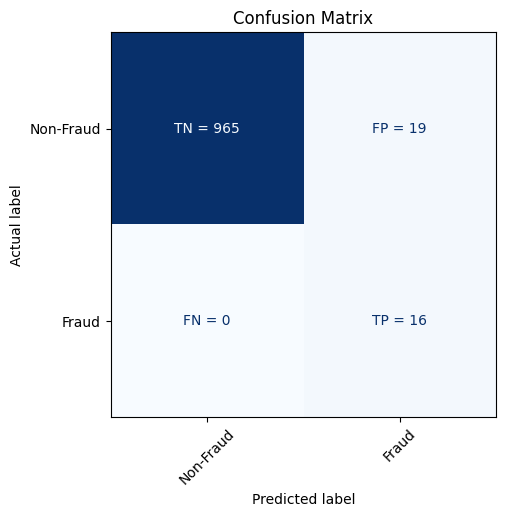

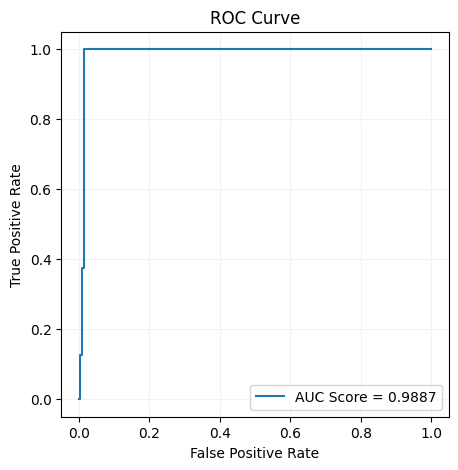

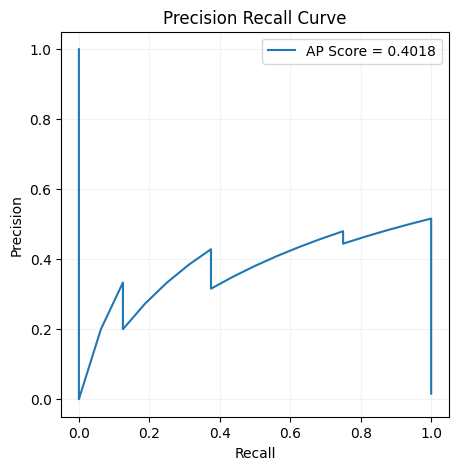

In [6]:
t = mp.Tester(model, torch.device('cpu'), test_dl)
results = t.test_results_binary()
mplt.TestPlot.print_binary_classification_report(results)
mplt.TestPlot.plot_binary_confusion_matrix(results, fig_size=(5,5))
mplt.TestPlot.plot_roc_curve(results, fig_size=(5,5))
mplt.TestPlot.plot_precision_recall_curve(results, fig_size=(5,5))

## Trials with RayTune
RayTune allows us to run trial of various types. Let's first try to run a couple of trial where we try and find the optimal settings for our `AdamW optimizer`. We're going to do this through a grid search, which basically means a full extensive search of the entire parameter space.


### Grid Search of Learning Rate
First we define a trail config, it contains the 2 parameters we would like to play around with during our trials. In this case we have defined 2 parameters
- The **Learning Rate** for which we define 5 values.
- The **Weight Decay**; (which normalises the weights, it penalizes weights with a large l2 norm), fir which we define 3 values.

A grid search will test each combination of the parameters, it's cartesian product, so we will get 5*3 = 15 trials


In [7]:
config = {
    "lr": tune.grid_search([0.001, 0.003, 0.01, 0.03, 0.1]),
    "wd": tune.grid_search([0.001, 0.01, 0.1])
}

Next up we define some general parameters and our data loaders.

In [8]:
mc           = mp.ModelConfiguration.from_tensor_definitions(ti.target_tensor_def)
EPOCS        = 10
NR_OF_TRIALS = 1
batch_size   = 32
cpu          = torch.device('cpu')

train_dl = train_ds.data_loader(cpu, batch_size, num_workers=2, sampler=train_sampler)
val_dl   = val_ds.data_loader(cpu, batch_size, num_workers=2)
test_dl  = test_ds.data_loader(cpu, batch_size, num_workers=2)

Before we tune we need to create a function RayTune can call to start each trial. The input to the function is a `config` object. The logic in the function will; 
- Create a model instance we are going to train. Here we call it **model**
- Create a `RayTrainer`, this is a specialisation of our regular trainer and will report the loss to RayTune after each EPOCH it runs.
- Create an optimizer. Note how here we inject the parameters specific to the trial from the config object we receive as input.
- Then we just train the created model

In [9]:
def train_model(config):

    model = SecondModel(mc, 0.6, 2, 5, 0.1)
    
    trainer = rt.RayTrainer(model, cpu, train_dl, val_dl)
    optimizer = mp.AdamWOptimizer(model, lr=config['lr'], wd=config['wd'])
    
    _ = trainer.train(EPOCS, optimizer)

We can also define a scheduler that can stop bad trials early. Here we define a Asynchronous Hyperband Scheduler. We tell it we want to target the `loss`, which we want to `min`. That we want a max number of `EPOCHS` and that the a `grace_period` of 2, basically saying we want at least 2 EPOCHS per trial.

This scheduler will basically stop trials after a minimum of 2 trail if the loss is not getting low enough as compared to other trials.

In [10]:
scheduler = ASHAScheduler(
    metric="loss",
    mode="min",
    max_t=EPOCS,
    grace_period=2
)

Becauye we are in a notebook, we build a notebook reporter which will show the trial results in a notebook friendly manner

In [11]:
grid_reporter = JupyterNotebookReporter(
    metric_columns=["loss", "training_iteration"], 
    parameter_columns= [k for k, _ in config.items()]
)

And finally we are are ready to start testing. This line will start 15 trials each with a different wd and lr parameter. The loss columns is what we need to look at, we're trying to find the trial with the lowest loss.

In [12]:
grid_trials = tune.run(
    train_model,
    resources_per_trial={"cpu": 5, "gpu": 1},
    config=config,
    num_samples=NR_OF_TRIALS,
    scheduler=scheduler,
    progress_reporter=grid_reporter,
    checkpoint_at_end=False
)

2023-04-21 22:58:58,364	INFO worker.py:1553 -- Started a local Ray instance.


Trial name,date,done,episodes_total,experiment_id,hostname,iterations_since_restore,loss,node_ip,pid,should_checkpoint,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
train_model_56455_00000,2023-04-21_22-59-04,True,,1522339db8464c9385eae39ca4657510,toms-ai3,10,0.1039,10.0.0.210,323339,True,3.69052,0.329939,3.69052,1682110744,0,,10,56455_00000,0.00167251
train_model_56455_00001,2023-04-21_22-59-10,True,,e8f41b5609984b39825d852a885ec8d2,toms-ai3,10,0.0668,10.0.0.210,325083,True,3.70529,0.319273,3.70529,1682110750,0,,10,56455_00001,0.00182819
train_model_56455_00002,2023-04-21_22-59-16,True,,2eb63c987f32475a98525a4627da68b3,toms-ai3,10,0.0594,10.0.0.210,326795,True,3.70851,0.341194,3.70851,1682110756,0,,10,56455_00002,0.00173068
train_model_56455_00003,2023-04-21_22-59-21,True,,5479cf9a13d64d52aa1ed94dea49115d,toms-ai3,10,0.0474,10.0.0.210,328536,True,3.69752,0.338963,3.69752,1682110761,0,,10,56455_00003,0.00171757
train_model_56455_00004,2023-04-21_22-59-28,True,,813a5a34907b42508e67ad93b0952eb8,toms-ai3,10,0.0304,10.0.0.210,330239,True,3.77793,0.344176,3.77793,1682110768,0,,10,56455_00004,0.00190687
train_model_56455_00005,2023-04-21_22-59-31,True,,c48d96d6f7d24f0f92f5d9dc2a185c0c,toms-ai3,2,0.4527,10.0.0.210,331946,True,0.934628,0.37348,0.934628,1682110771,0,,2,56455_00005,0.00165224
train_model_56455_00006,2023-04-21_22-59-34,True,,a0a23385acd940d2b9f117d2add24d47,toms-ai3,2,0.1403,10.0.0.210,332392,True,0.965295,0.373899,0.965295,1682110774,0,,2,56455_00006,0.00160694
train_model_56455_00007,2023-04-21_22-59-37,True,,2e651ae3dc544b9cb06bc0b5c2aff005,toms-ai3,2,0.0723,10.0.0.210,332839,True,0.957078,0.362796,0.957078,1682110777,0,,2,56455_00007,0.00166273
train_model_56455_00008,2023-04-21_22-59-41,True,,111c784b20d4422a91e3470a59a0596b,toms-ai3,8,0.0537,10.0.0.210,333285,True,2.44455,0.256538,2.44455,1682110781,0,,8,56455_00008,0.00829887
train_model_56455_00009,2023-04-21_22-59-46,True,,f48cbc3808364c55bf26b3585a94ce66,toms-ai3,10,0.0374,10.0.0.210,334675,True,3.04762,0.269121,3.04762,1682110786,0,,10,56455_00009,0.00157595


2023-04-21 23:00:02,851	INFO tune.py:798 -- Total run time: 63.76 seconds (63.75 seconds for the tuning loop).


We see that we can try a higher Learning rate and a slightly lower weight_decay that standard (0.01) for the Pytorch `AdamW` optimizer. See https://pytorch.org/docs/stable/generated/torch.optim.AdamW.html#torch.optim.AdamW

Let's plug those into a new model and optimizer and see what happens.

In [13]:
model   = SecondModel(mc, 0.6, 2, 5, 0.1)
trainer = mp.Trainer(model, torch.device('cpu'), train_dl, val_dl)
# Then an optimizer
optimizer = mp.AdamWOptimizer(model, lr=0.1, wd=0.001)
# Run the trainer for 10 epochs
history = trainer.train(10, optimizer)

Epoch 010/010: 100%|██████████| 282/282 [00:00<00:00, 828.67it/s, t_loss=0.0234, t_acc=0.993, v_loss=0.0404, v_acc=0.987]      


This should have given us a lower loss (v_loss) on the last epoch as compared to the first run.

Also we should see the shape of the AP curve change dramatically. This indicates our model is much better at seperating out the fraud from the non-fraud.

Testing in 32 steps: 100%|█████████████████████| 32/32 [00:00<00:00, 416.71it/s]


------------- Classification report -----------------
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99       984
         1.0       0.52      1.00      0.68        16

    accuracy                           0.98      1000
   macro avg       0.76      0.99      0.84      1000
weighted avg       0.99      0.98      0.99      1000


auc score : 0.9981
ap score  : 0.9065
-----------------------------------------------------


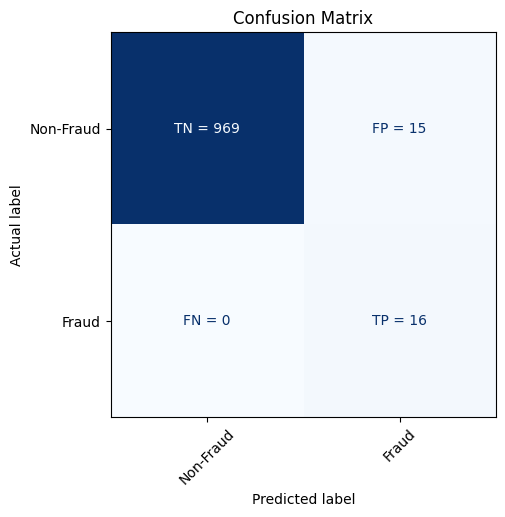

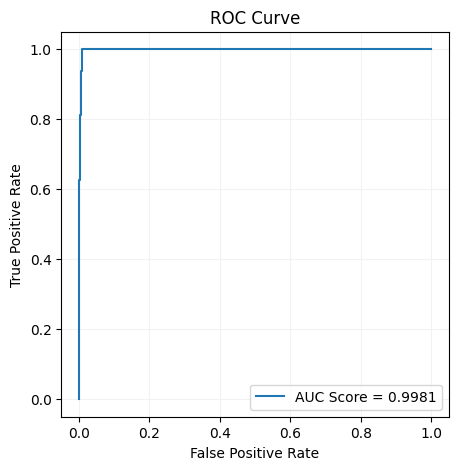

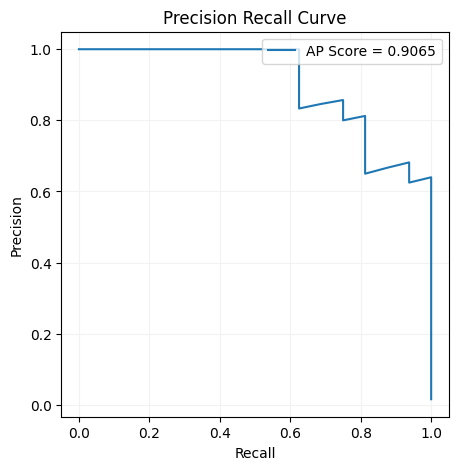

In [14]:
t = mp.Tester(model, torch.device('cpu'), test_dl)
results = t.test_results_binary()
mplt.TestPlot.print_binary_classification_report(results)
mplt.TestPlot.plot_binary_confusion_matrix(results, fig_size=(5,5))
mplt.TestPlot.plot_roc_curve(results, fig_size=(5,5))
mplt.TestPlot.plot_precision_recall_curve(results, fig_size=(5,5))

## Random Search
In some cases a full grid search become non-tractable, for instance if we have a lot of parameter we want to tune and these parameters have a lot of different values they can take on. A full grid search would create a -cartesian- number of trials.

In those cases a Random search can help. So let's say we feel like not only tuning our Learning rate, but also the settings that determine the size of the Embeddings in the Model heads.

We first add the 4 'Heads' parameters to the config.

In [15]:
config = {
    "dim_ratio": tune.sample_from(lambda _: np.random.uniform(0.4, 0.7)),
    "min_dims": tune.choice([5, 10]),
    "max_dims": tune.choice([10, 20, 30]),
    "dropout": tune.sample_from(lambda _: np.random.uniform(0.05, 0.2)),
    "lr": tune.sample_from(lambda _: np.random.uniform(0.01, 0.2)),
    "wd": tune.sample_from(lambda _: np.random.uniform(0.0005, 0.01)),
}

Because we are no longer grid searching we need to specify an exact number of trials we want to run.

In [16]:
NR_OF_TRIALS = 20

Now, important! As we now also want to feed some parameters into the model (as oposed to having optimizer parameters in the grid search). Remember how in the beginning when we defined the model, we created the 'SecondModel' so that it can take the 'heads' parameters as input. We are now using those to feed in various trial settings.

In [17]:
def train_model(config):
  
    model = SecondModel(mc, config['dim_ratio'],config['min_dims'], config['max_dims'], config['dropout'])
    
    trainer = rt.RayTrainer(model, cpu, train_dl, val_dl)
    optimizer = mp.AdamWOptimizer(model, lr=config['lr'])
    
    _ = trainer.train(EPOCS, optimizer)

We also need to reconfigure the reporter so it takes our new paramters into consideration

In [18]:
random_reporter = JupyterNotebookReporter(
    metric_columns=["loss", "training_iteration"], 
    parameter_columns= [k for k, _ in config.items()]
)

And off to the races again. This time we will run 'NUMBER_OF_TRIALS' trials where we randomly search our `config` space. The search space now not only contains optimzizer parameters, but also model parameters, so the model will now be different for each trial.

In [19]:
random_result = tune.run(
    train_model,
    resources_per_trial={"cpu": 5, "gpu": 1},
    config=config,
    num_samples=NR_OF_TRIALS,
    scheduler=scheduler,
    progress_reporter=random_reporter,
    checkpoint_at_end=False
)

Trial name,date,done,episodes_total,experiment_id,hostname,iterations_since_restore,loss,node_ip,pid,should_checkpoint,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
train_model_a7941_00000,2023-04-21_23-01-20,True,,3a174f680f3b4e56abf25a628d2d5f5f,toms-ai3,8,0.0507,10.0.0.210,341304,True,2.96897,0.34397,2.96897,1682110880,0,,8,a7941_00000,0.00174117
train_model_a7941_00001,2023-04-21_23-01-25,True,,c19553c3de864c4ea5e0e291d6321077,toms-ai3,8,0.0541,10.0.0.210,342693,True,3.07249,0.374201,3.07249,1682110885,0,,8,a7941_00001,0.00166535
train_model_a7941_00002,2023-04-21_23-01-28,True,,1723e78df92c4d4683efee26ef5e5a71,toms-ai3,2,0.0638,10.0.0.210,344083,True,0.953523,0.395575,0.953523,1682110888,0,,2,a7941_00002,0.00167847
train_model_a7941_00003,2023-04-21_23-01-34,True,,a1f7d0dda7274a179a3d6fbf73c67127,toms-ai3,10,0.0367,10.0.0.210,344530,True,3.70237,0.341875,3.70237,1682110894,0,,10,a7941_00003,0.00172687
train_model_a7941_00004,2023-04-21_23-01-39,True,,97cfeeaa499c42ecb5ecbcb04b78bd12,toms-ai3,8,0.0522,10.0.0.210,346233,True,3.11338,0.357811,3.11338,1682110899,0,,8,a7941_00004,0.00171113
train_model_a7941_00005,2023-04-21_23-01-42,True,,c2384138ce1540cf97854470efc35684,toms-ai3,2,0.063,10.0.0.210,347630,True,0.943604,0.362134,0.943604,1682110902,0,,2,a7941_00005,0.0018456
train_model_a7941_00006,2023-04-21_23-01-45,True,,445f3493e7ee4f2d8093d9fa48d37bb1,toms-ai3,2,0.0701,10.0.0.210,348076,True,0.96428,0.383141,0.96428,1682110905,0,,2,a7941_00006,0.00177789
train_model_a7941_00007,2023-04-21_23-01-50,True,,9703fcb6f44b459f8910a0f5097fd1d5,toms-ai3,8,0.0502,10.0.0.210,348525,True,3.23667,0.392461,3.23667,1682110910,0,,8,a7941_00007,0.00181103
train_model_a7941_00008,2023-04-21_23-01-56,True,,2e1e67dba8bc44d1ba48643b9e064179,toms-ai3,10,0.049,10.0.0.210,349914,True,3.96946,0.37521,3.96946,1682110916,0,,10,a7941_00008,0.00170517
train_model_a7941_00009,2023-04-21_23-02-00,True,,8b04730dc5d24dd994ec57998b4fcf95,toms-ai3,8,0.0518,10.0.0.210,351618,True,2.58664,0.274632,2.58664,1682110920,0,,8,a7941_00009,0.00177717


2023-04-21 23:02:37,209	INFO tune.py:798 -- Total run time: 81.71 seconds (81.69 seconds for the tuning loop).


The trails are not always conslusive, this model is a bit small. But we could try and slightly increase the dimensions of the embedding layers and drop-out and decrease the weight_decay  a bit.

In [20]:
model   = SecondModel(mc, 0.6, 10, 30, 0.1)
trainer = mp.Trainer(model, torch.device('cpu'), train_dl, val_dl)
optimizer = mp.AdamWOptimizer(model, lr=0.1, wd=0.009)
# Run the trainer for 10 epochs
history = trainer.train(10, optimizer)

Epoch 010/010: 100%|██████████| 282/282 [00:00<00:00, 830.84it/s, t_loss=0.0391, t_acc=0.99, v_loss=0.0468, v_acc=0.985]       


The results don't get better, turns out our grid-searched parameters were pretty good.

Testing in 32 steps: 100%|█████████████████████| 32/32 [00:00<00:00, 415.68it/s]


------------- Classification report -----------------
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99       984
         1.0       0.52      1.00      0.68        16

    accuracy                           0.98      1000
   macro avg       0.76      0.99      0.84      1000
weighted avg       0.99      0.98      0.99      1000


auc score : 0.9984
ap score  : 0.9132
-----------------------------------------------------


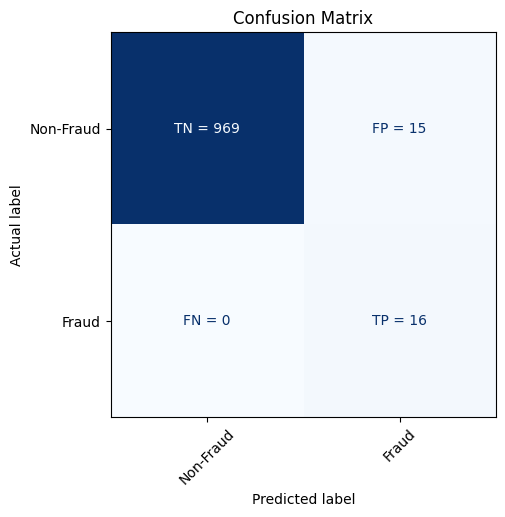

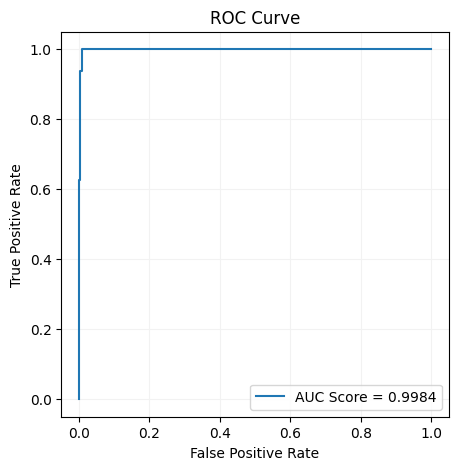

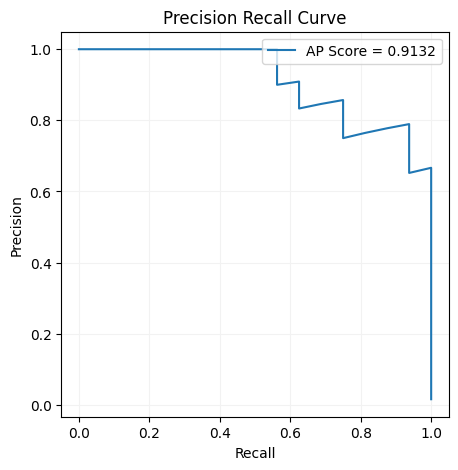

In [21]:
t = mp.Tester(model, torch.device('cpu'), test_dl)
results = t.test_results_binary()
mplt.TestPlot.print_binary_classification_report(results)
mplt.TestPlot.plot_binary_confusion_matrix(results, fig_size=(5,5))
mplt.TestPlot.plot_roc_curve(results, fig_size=(5,5))
mplt.TestPlot.plot_precision_recall_curve(results, fig_size=(5,5))

## Population Based Search

Another type of optimisation we can try is a population based search. Population based searches were created to train a series of models at the same time. It draws some inspiration from genetic algorithms where each the population of parameters is mutated and crossed to form new sets of parameters. Trials can be stopped and restarted.

We will have to revert to tuning the optimizer parameters; with population based matching the model is persisted and reloaded, if you change the lay-out and the layer sizes, they can not be re-loaded. So we cannot be feeding parameters that would change the model layout.

In [22]:
config = {
    "lr": tune.sample_from(lambda _: np.random.uniform(0.01, 0.2)),
    "wd": tune.sample_from(lambda _: np.random.uniform(0.0005, 0.01)),
}

In [23]:
def train_model(config):

    model   = SecondModel(mc, 0.6, 10, 30, 0.1)
    
    trainer = rt.RayTrainer(model, cpu, train_dl, val_dl)
    optimizer = mp.AdamWOptimizer(model, lr=config['lr'], wd=config['wd'])
    
    _ = trainer.train(EPOCS, optimizer)

Population based training is set-up as a sheduler. So we do not need the AHAS.

In [24]:
pbt = PopulationBasedTraining(
    time_attr="training_iteration",
    metric="loss",
    mode="min",
    perturbation_interval=2,  
    hyperparam_mutations={
        "lr": tune.uniform(0.01, 0.2),
        "wd": tune.uniform(0.0005, 0.01)
    })

We do need a new reporter.

In [25]:
pbt_reporter = JupyterNotebookReporter(
    metric_columns=["loss", "training_iteration"], 
    parameter_columns= [k for k, _ in config.items()]
)

And we're ready to test, we ask for 10 trials and to stop after 10 epocs.

In [ ]:
pbt_result = tune.run(
    train_model,
    resources_per_trial={"cpu": 5, "gpu": 1},
    config=config,
    num_samples=10,
    scheduler=pbt,
    stop = {"training_iteration" : 10},
    progress_reporter=pbt_reporter,
    checkpoint_at_end=False,
    reuse_actors=True,
    verbose=True
)

From the trial, it does look we could try with a slightly higher lower learning rate, but higher weight_decay

In [27]:
model   = SecondModel(mc, 0.6, 10, 30, 0.1)
trainer = mp.Trainer(model, torch.device('cpu'), train_dl, val_dl)
# Then an optimizer
optimizer = mp.AdamWOptimizer(model, lr=0.09, wd=0.001)
# Run the trainer for 10 epochs
history = trainer.train(10, optimizer)

Epoch 010/010: 100%|██████████| 282/282 [00:00<00:00, 802.76it/s, t_loss=0.0323, t_acc=0.991, v_loss=0.0507, v_acc=0.985]      


Testing in 32 steps: 100%|█████████████████████| 32/32 [00:00<00:00, 400.62it/s]


------------- Classification report -----------------
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99       984
         1.0       0.52      1.00      0.68        16

    accuracy                           0.98      1000
   macro avg       0.76      0.99      0.84      1000
weighted avg       0.99      0.98      0.99      1000


auc score : 0.9993
ap score  : 0.9673
-----------------------------------------------------


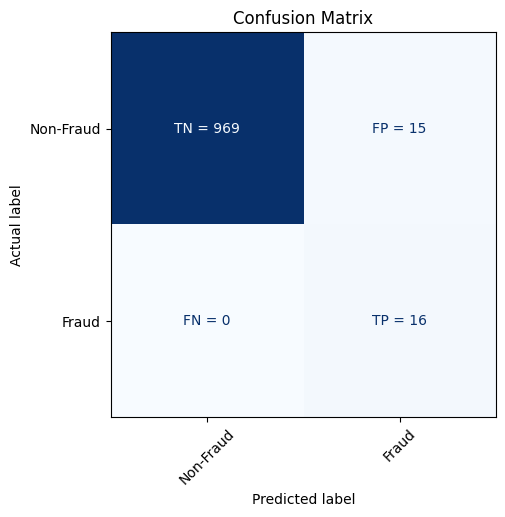

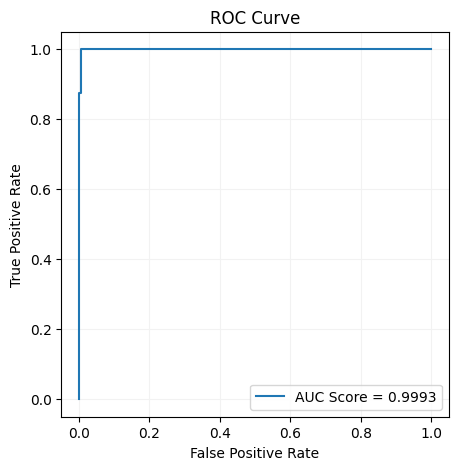

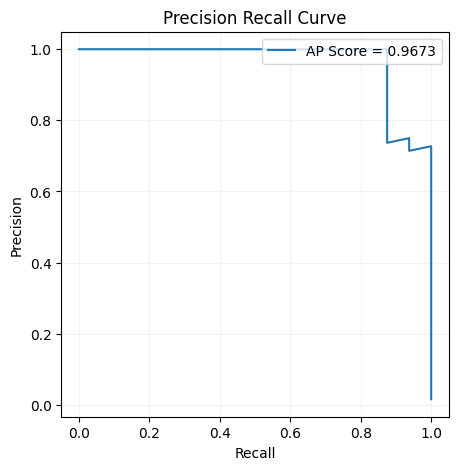

In [28]:
t = mp.Tester(model, torch.device('cpu'), test_dl)
results = t.test_results_binary()
mplt.TestPlot.print_binary_classification_report(results)
mplt.TestPlot.plot_binary_confusion_matrix(results, fig_size=(5,5))
mplt.TestPlot.plot_roc_curve(results, fig_size=(5,5))
mplt.TestPlot.plot_precision_recall_curve(results, fig_size=(5,5))

## Conclusion

Having tools to run trials is very important for fine-tuning complex model. Ray also support other optimizers like HyperOpt and Optuna. Check the [Ray Docs](https://docs.ray.io/en/latest/tune/api/suggestion.html) for more information